In [1]:
# 1. Setup and Installation
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Random Seed for Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check Device
# 만약 GPU 에러가 계속 나면 아래 줄을 device = torch.device("cpu") 로 바꾸세요.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

Current Device: cpu


In [2]:
# 2. Dataset Preparation
# Load data
if not os.path.exists("data.csv"):
    print("Error: 'data.csv' not found. Please place the csv file in the same directory.")
else:
    df = pd.read_csv("data.csv")
    
    # Preprocess: Clean column names to lower case to prevent KeyError
    df.columns = df.columns.str.strip().str.lower()
    
    # Check data
    print(f"Data Shape: {df.shape}")
    print(df.head())

    # Label Mapping
    label_map = {0: "All-or-Nothing", 1: "Catastrophizing", 2: "Should Statements"}

    # Split Data (80% Train, 20% Test) - Stratified
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Data Shape: (293, 3)
                              text  label  note
0      이번 시험에서 1등을 못 하면 난 완전 실패자야.      0  흑백논리
1            내 편이 아니면 너는 내 적일 뿐이야.      0  흑백논리
2  프로젝트가 완벽하지 않으면 아예 제출 안 하는 게 나아.      0  흑백논리
3       그 사람은 나를 전혀 사랑하지 않는 게 분명해.      0  흑백논리
4         한 번이라도 실수하면 그건 전문가가 아니야.      0  흑백논리
Train samples: 234, Test samples: 59


In [3]:
# 3. Naive Baseline (Rule-based)
class NaiveKeywordClassifier:
    def __init__(self):
        # Define keywords for each class
        self.keywords = {
            0: ["전부", "모두", "아니면", "완벽", "망했", "실패", "1등", "최고", "쓰레기", "적", "배신", "없어"],
            1: ["죽을", "큰일", "끔찍", "심장", "망할", "파산", "끝장", "어떡하지", "무서워", "불안", "영원히"],
            2: ["해야", "당연", "의무", "도리", "상식", "예의", "기본", "무조건", "절대", "감히"]
        }

    def predict(self, text):
        text = str(text)
        counts = {0: 0, 1: 0, 2: 0}

        # Count keywords
        for label, words in self.keywords.items():
            for word in words:
                if word in text:
                    counts[label] += 1
        
        # Max count selection
        max_val = max(counts.values())
        if max_val == 0:
            return random.choice([0, 1, 2])
            
        candidates = [k for k, v in counts.items() if v == max_val]
        return random.choice(candidates)

# Evaluate Baseline
baseline_model = NaiveKeywordClassifier()
baseline_preds = [baseline_model.predict(t) for t in test_df['text']]
baseline_acc = accuracy_score(test_df['label'], baseline_preds)

print(f"\n[Baseline] Accuracy: {baseline_acc:.4f}")


[Baseline] Accuracy: 0.5932


In [4]:
# 4. AI Pipeline (Fine-tuning BERT)
print("\nStarting AI Training...")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Load Model & Tokenizer
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none"  # Disable wandb logging to keep it simple
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# Train
trainer.train()

# Predict
predictions = trainer.predict(tokenized_test)
ai_preds = np.argmax(predictions.predictions, axis=1)
ai_acc = accuracy_score(test_df['label'], ai_preds)

print(f"\n[AI Model] Accuracy: {ai_acc:.4f}")


Starting AI Training...


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

c:\Users\kimga\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kimga\.cache\huggingface\hub\models--klue--bert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.767944,0.728814
2,No log,0.577677,0.864407
3,No log,0.518738,0.915254



[AI Model] Accuracy: 0.9153


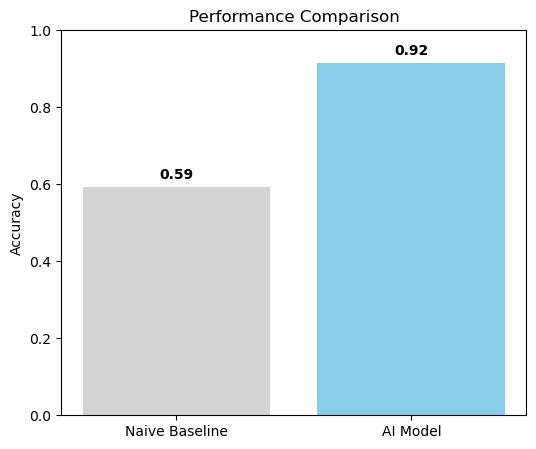


--- Improvement Cases (AI Correct vs Baseline Wrong) ---
Text: 회식도 업무의 연장이야, 빠지는 건 직무 유기지
True: Should Statements | Baseline: All-or-Nothing | AI: Should Statements
--------------------------------------------------
Text: 다들 짝이 있는데 나만 솔로야, 난 평생 고독사 확정임
True: All-or-Nothing | Baseline: Should Statements | AI: All-or-Nothing
--------------------------------------------------
Text: 중간고사를 조졌으니 기말고사 잘 봐봤자 학점 세탁은 불가능해
True: All-or-Nothing | Baseline: Catastrophizing | AI: All-or-Nothing
--------------------------------------------------


In [5]:
# 5. Result Visualization & Analysis

# Bar Chart
plt.figure(figsize=(6, 5))
plt.bar(['Naive Baseline', 'AI Model'], [baseline_acc, ai_acc], color=['lightgray', 'skyblue'])
plt.title('Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate([baseline_acc, ai_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# Qualitative Analysis
print("\n--- Improvement Cases (AI Correct vs Baseline Wrong) ---")
count = 0
for i in range(len(test_df)):
    true_label = test_df.iloc[i]['label']
    base_p = baseline_preds[i]
    ai_p = ai_preds[i]
    
    if base_p != true_label and ai_p == true_label:
        print(f"Text: {test_df.iloc[i]['text']}")
        print(f"True: {label_map[true_label]} | Baseline: {label_map[base_p]} | AI: {label_map[ai_p]}")
        print("-" * 50)
        count += 1
        if count >= 3: break